# Упражнение Мультиклассовая Support Vector Machine

В этом упражнении вы:
    
- реализуете полностью векторизированную **функцию потерь** для SVM;
- реализуете полностью векторизированное выражение для её **аналитического градиента**;
- **проверите свою реализацию**, используя числовой градиент;
- будете использовать валидационный набор для **настройки скорости обучения и силы регуляризации**;
- **оптимизируете** функцию потерь с помощью **SGD**;
- **визуализируете** итоговые обученные веса.

In [1]:
# Запустим установочный код для этого ноутбука.

import os

import numpy as np
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

# Немного магии, позволяющей отображать matplotlib-рисунки в ноутбуке, а не в новом окне.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # установим размер графиков по умолчанию
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Ещё немного магии, чтобы ноутбук перезагрузил внешние модули Python;
# Смотри http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Загрузка и предварительная обработка набора CIFAR-10

In [2]:
# Загрузим необработанный набор данных CIFAR-10.
cifar10_dir = os.path.join("cs231n", "datasets", "cifar-10-batches-py")

# Очистка переменных для предотвращения многократной загрузки данных (что может вызвать проблемы с памятью).
try:
    del X_train, y_train
    del X_test, y_test
    print("Ранее загруженные данные очищены.")
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# В качестве проверки работоспособности мы распечатываем размер обучающих и тестовых данных.
print("Форма обучающих данных:", X_train.shape)
print("Форма обучающих меток: ", y_train.shape)
print("Форма тестовых данных: ", X_test.shape)
print("Форма тестовых меток:  ", y_test.shape)

Форма обучающих данных: (50000, 32, 32, 3)
Форма обучающих меток:  (50000,)
Форма тестовых данных:  (10000, 32, 32, 3)
Форма тестовых меток:   (10000,)


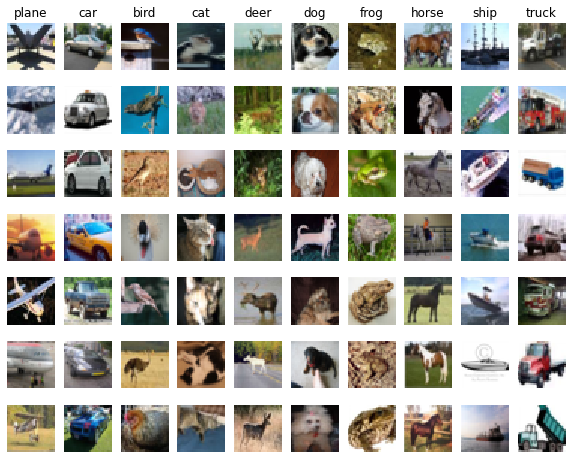

In [3]:
# Визуализируем несколько примеров из набора данных.
# Мы показываем несколько примеров обучающих изображений из каждого класса.
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Разделим набор данных на обучающую, валидационную и тестовую части.
# Кроме того, мы создадим небольшой набор для разработки как подмножество
# обучающих данных; мы можем использовать его для разработки, чтобы наш
# код работал быстрее.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Наша валидационная часть будет состоять из num_validation точек данных
# из исходного обучающего набора.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Наша обучающая часть будет состоять из первых num_train точек данных
# из исходного обучающего набора.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Мы также создаём набор данных для разработки, который является
# подвыборкой из новой обучающей части.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Мы используем первые num_test точки данных из исходного тестового набора
# в качестве нашей тестовой части.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", y_train.shape)
print("Форма валидационных данных: ", X_val.shape)
print("Форма валидационных меток:  ", y_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма тестовых меток:       ", y_test.shape)
print("Форма данных для разработки:", X_dev.shape)
print("Форма меток для разработки: ", y_dev.shape)

Форма обучающих данных:      (49000, 32, 32, 3)
Форма обучающих меток:       (49000,)
Форма валидационных данных:  (1000, 32, 32, 3)
Форма валидационных меток:   (1000,)
Форма тестовых данных:       (1000, 32, 32, 3)
Форма тестовых меток:        (1000,)
Форма данных для разработки: (500, 32, 32, 3)
Форма меток для разработки:  (500,)


In [5]:
# Предобработка: преобразуем изображения в векторы-строки
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# В качестве проверки мы распечатываем размер обучающих и тестовых данных.
print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", X_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма данных для разработки:", X_dev.shape)

Форма обучающих данных:      (49000, 3072)
Форма обучающих меток:       (1000, 3072)
Форма тестовых данных:       (1000, 3072)
Форма данных для разработки: (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


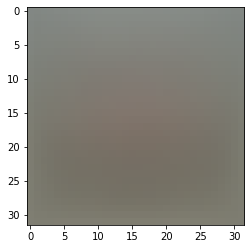

Форма обучающих данных:      (49000, 3073)
Форма обучающих меток:       (1000, 3073)
Форма тестовых данных:       (1000, 3073)
Форма данных для разработки: (500, 3073)


In [6]:
# Предобработка: вычитание среднего арифметического изображения
# Во-первых: вычислим среднее арифметическое изображение по обучающей части
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])  # распечатаем несколько элементов
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype("uint8"))  # визуализируем среднее арифметическое изображение
plt.show()

# Во-вторых: вычтем среднее арифметического изображение из обучающих и тестовых данных
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# В-третьих: добавим размерность смещения, заполненную единицами (т.е. трюк со смещением),
# таким образом, чтобы наша SVM беспокоилась только об оптимизации единой матрицы весов W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", X_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма данных для разработки:", X_dev.shape)

## SVM-классификатор

Для этого раздела вы будете писать код в `cs231n/classifiers/linear_svm.py`. 

Как вы можете видеть, мы предварительно написали функцию `svm_loss_naive`, которая использует циклы for для оценки функции потерь мультиклассовой SVM. 

In [7]:
# Оцените наивную реализацию функции потерь, которую мы вам предоставили:
from cs231n.classifiers.linear_svm import svm_loss_naive


# сгенерируем случайную весовую матрицу SVM из небольших чисел
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print("потеря: %f" % loss)

потеря: 9.246576


`grad`, возвращаемый приведённой выше функцией сейчас состоит из нулей. Выведите и реализуйте вычисление аналитического градиента для функции потерь SVM в функции `svm_loss_naive`. Вам будет полезно чередовать ваш новый код внутри существующей функции.

Чтобы убедиться, что вы правильно реализовали вычисление градиента, вы можете численно оценить градиент функции потерь и сравнить численную оценку с вычисленным вами градиентом. Мы предоставили код, который делает это за вас:

In [8]:
# Как только вы реализовали вычисление аналитического градиента, пересчитайте
# его с помощью кода ниже и осуществите проверку градиента с помощью функции,
# которую мы вам предоставили.

# Вычислите потери и их градиент при W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Численно вычислим градиент по нескольким случайно выбранным измерениям и
# сравним их с вашим аналитически вычисленным градиентом. Числа должны почти
# точно совпадать по всем измерениям.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Ещё раз проверим градиент с включенной регуляризацией. Вы не забыли
# регуляризацию градиента, не так ли?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Проверка началась.
Численный: -20.410806, аналитический: -20.410806, относительная ошибка: 9.831107e-12
Численный: 25.841629, аналитический: 25.841629, относительная ошибка: 3.409923e-12
Численный: -3.394107, аналитический: -3.394107, относительная ошибка: 6.509724e-11
Численный: 30.351444, аналитический: 30.351444, относительная ошибка: 1.161951e-11
Численный: -38.366359, аналитический: -38.366359, относительная ошибка: 3.173670e-12
Численный: 23.174808, аналитический: 23.174808, относительная ошибка: 3.914839e-12
Численный: 13.208883, аналитический: 13.208883, относительная ошибка: 4.777136e-12
Численный: 31.711029, аналитический: 31.711029, относительная ошибка: 9.145952e-12
Численный: 7.324549, аналитический: 7.324549, относительная ошибка: 7.113928e-12
Численный: 10.089602, аналитический: 10.089602, относительная ошибка: 4.570277e-11
Проверка закончилась.
Проверка началась.
Численный: -27.636168, аналитический: -27.642192, относительная ошибка: 1.089860e-04
Численный: 10.965831, а

**Вопрос 1**

1. Возможно, что время от времени измерение в проверке градиента не будет точно совпадать?  
2. Чем могло быть вызвано такое несоответствие?  
3. Стоит ли об этом обеспокоиться?  
4. Приведите простой пример для одного измерения, в котором проверка градиента завершится неудачей.  
5. Как изменится маржинальный эффект от частоты этого события?  
*Подсказка: функция потерь SVM, строго говоря, не дифференцируема*

**Мой ответ 1**

1. Да, это возможно.
2. Несоответствие могло быть вызвано вычислением неверного градиента функцией max(o, x), которая имеет излом в x=0 и не дифференцируема.
3. Да, стоит.
4. В качестве простого примера, если x=-1e-8, то max(0, x)=0, аналитический градиент равен 0; однако численный градиент может отличаться, если мы считаем, что h больше x, например, h=1e-6. Это будет по-другому, потому что, когда мы вычисляем f(x+h) = max(0, x+h) = c > 0, таким образом, числовой градиент будет отличаться от 0.
5. Чтобы избежать частоты возникновения этой проблемы, мы могли бы учитывать небольшое количество точек данных при расчете градиента, потому что при меньшем количестве точек данных у нас будет меньше перегибов. Другой подход, который обычно используется для вычисления градиента, известен как субградиент.

In [9]:
# Далее реализуйте функцию svm_loss_vectorized; пока только вычисление потери;
# мы реализуем вычисление градиента в один миг.
import time
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Наивная потеря:         %e вычислена за %fs секунд." % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Векторизованная потеря: %e вычислена за %fs секунд." % (loss_vectorized, toc - tic))

# Потери должны совпадать, но ваша векторизованная реализация должна быть намного быстрее.
print("Разница: %f." % (loss_naive - loss_vectorized))

Наивная потеря:         9.246576e+00 вычислена за 0.154904s секунд.
Векторизованная потеря: 9.246576e+00 вычислена за 0.006002s секунд.
Разница: -0.000000.


In [10]:
# Завершите реализацию svm_loss_vectorized и вычислите градиент функции потерь
# векторизованным способом.

# Наивная реализация и векторизованная реализация должны совпадать, но
# векторизованная версия также должна быть намного быстрее.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Наивная потеря и градиент вычислены за %fs секунд." % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Векторизованная потеря и градиент вычислены за %fs секунд." % (toc - tic))

# Потеря представляет собой одно число, поэтому легко сравнить значения,
# вычисленные двумя реализациями. Градиент, с другой стороны, является
# матрицей, поэтому мы используем норму Фробениуса для их сравнения.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord="fro")
print("Разница: %f." % difference)

Наивная потеря и градиент вычислены за 0.172894s секунд.
Векторизованная потеря и градиент вычислены за 0.009997s секунд.
Разница: 0.000000.


### Стохастический Градиентный Спуск

Теперь у нас есть векторизованные и эффективные выражения для потерь, градиента, и наш градиент соответствует числовому градиенту. Следовательно мы готовы сделать SGD, чтобы минимизировать потери. Ваш код для этой части будет написан внутри `cs231n/classifiers/linear_classifier.py`.

In [ ]:
# В файле linear_classifier.py, реализуйте SGD в методе LinearClassifier.train(),
# а затем запустите его с помощью приведённого ниже кода.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print("That took %fs" % (toc - tic))

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel("Iteration number")
plt.ylabel("Loss value")
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print("training accuracy: %f" % np.mean(y_train == y_train_pred))
y_val_pred = svm.predict(X_val)
print("validation accuracy: %f" % np.mean(y_val == y_val_pred))

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("lr %e reg %e train accuracy: %f val accuracy: %f" % (
                lr, reg, train_accuracy, val_accuracy))
    
print("best validation accuracy achieved during cross-validation: %f" % best_val)

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel("log learning rate")
plt.ylabel("log regularization strength")
plt.title("CIFAR-10 training accuracy")

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel("log learning rate")
plt.ylabel("log regularization strength")
plt.title("CIFAR-10 validation accuracy")
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("linear SVM on raw pixels final test set accuracy: %f" % test_accuracy)

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype("uint8"))
    plt.axis("off")
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
